# Mesh Geodesic Sampling Test - 颗粒挑选可视化

本 Notebook 演示 `tomopanda.core.mesh_geodesic.MeshGeodesicSampler` 的每一步：
1) 签名距离场 (SDF) 与平滑
2) Marching Cubes 网格提取 + Taubin 平滑 + 顶点法向
3) 网格面采样与 SDF 对齐法线 (Mesh Face Sampling with SDF-aligned Normals)
4) 非极大值抑制 (NMS)
5) 粒子可放置性检查 (边界约束)
6) 姿态先验（由法向导出）
7) 标准输出与可视化脚本生成（可选）
8) **新增**: 简化 RELION 格式输出与 3D 可视化

**更新说明**: 
- 现在使用基于网格面的采样方法，法线方向与 SDF 正值方向一致
- 测地最远点采样已被弃用，因为在大数据集上性能不佳
- **新增**: 支持简化 RELION 格式，只包含 9 个必要列
- **新增**: 支持 3D 可视化，正确显示膜表面法向量方向

We'll use a synthetic spherical mask for a quick demo.


In [1]:
# Imports and setup
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tomopanda.core.mesh_geodesic import (
    create_mesh_geodesic_sampler,
    generate_synthetic_mask,
    run_mesh_geodesic_sampling,
    save_sampling_outputs,
)

# For 3D plots (optional)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# NEW: Import utilities for RELION and visualization
from tomopanda.utils.mrc_utils import save_subtomogram_coordinates
from tomopanda.utils.relion_utils import RELIONConverter

np.random.seed(0)
print("Environment ready.")


Environment ready.


## 0) Create a synthetic spherical mask


In [2]:
#mask = generate_synthetic_mask(
#    shape=(100, 100, 100),  # (z, y, x)
#    center=(50, 50, 50),
#    radius=30,
#)
#print("Created synthetic mask:", mask.shape, mask.dtype, mask.sum())

from tomopanda.utils.mrc_utils import MRCReader

# 读取 A.mrc 作为 msk
my_mrc_file ='/Users/muwang/Downloads/rec_pinkss_MGS002_T2_ts_001_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc'
mask = MRCReader.read_membrane_mask(my_mrc_file)


print("Loaded mask from A.mrc:", mask.shape, mask.dtype, mask.sum())




Loaded mask from A.mrc: (335, 671, 671) uint8 2945498


# 1) Signed Distance Field (SDF) and smoothing


IndexError: index 167 is out of bounds for axis 0 with size 112

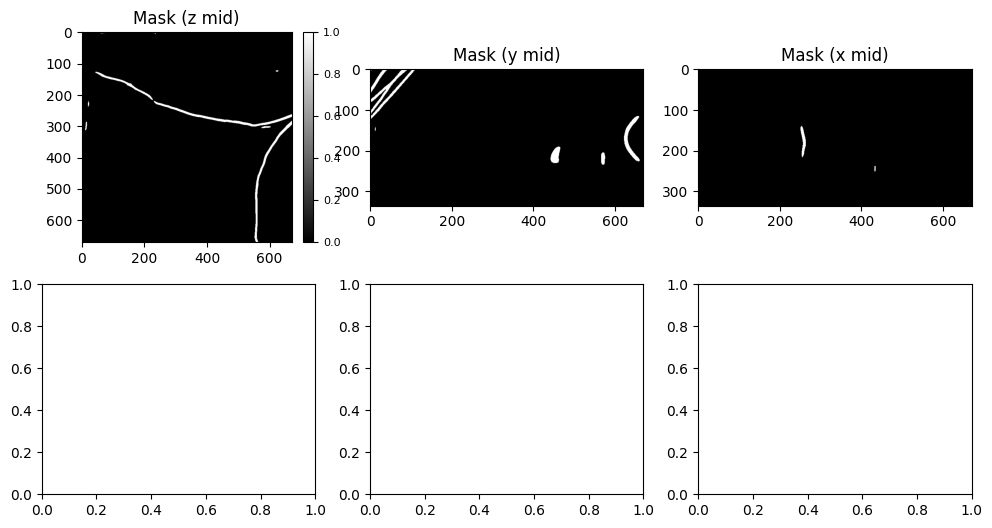

In [3]:
sampler = create_mesh_geodesic_sampler(
    expected_particle_size=20.0,  # 自动计算采样距离
    smoothing_sigma=1.5,
    taubin_iterations=10,
)
phi = sampler.create_signed_distance_field(mask)

# Visualize 3 central slices, with colorbars on the left of each row
import matplotlib as mpl

z, y, x = mask.shape
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# First row: mask slices, grayscale, colorbar on the left
for i, (data, title) in enumerate([
    (mask[min(z//2, z-1)], 'Mask (z mid)'),
    (mask[:, min(y//2, y-1), :], 'Mask (y mid)'),
    (mask[:, :, min(x//2, x-1)], 'Mask (x mid)'),
]):
    im = axs[0, i].imshow(data, cmap='gray')
    axs[0, i].set_title(title)
    if i == 0:
        # Add colorbar to the left of the first row
        cbar = fig.colorbar(im, ax=axs[0, i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

# Second row: SDF φ slices, custom diverging colormap, colorbar on the left
from matplotlib.colors import TwoSlopeNorm, ListedColormap

# Custom colormap: under 0 is blue, 0 is white, over 0 is red
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'custom_div',
    [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
norm = TwoSlopeNorm(vcenter=0)

for i, (data, title) in enumerate([
    (phi[min(z//2, z-1)], 'SDF φ (z mid)'),
    (phi[:, min(y//2, y-1), :], 'SDF φ (y mid)'),
    (phi[:, :, min(x//2, x-1)], 'SDF φ (x mid)'),
]):
    im = axs[1, i].imshow(data, cmap=cmap, norm=norm)
    axs[1, i].set_title(title)
    if i == 0:
        # Add colorbar to the left of the second row
        cbar = fig.colorbar(im, ax=axs[1, i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('SDF φ', fontsize=10)

plt.tight_layout()
plt.show()


# 2) Mesh extraction from φ=0 and smoothing + normals


In [ ]:
mesh = sampler.extract_mesh_from_sdf(phi)
verts = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)
len(verts), len(faces)


(1310383, 2605922)

# 3) Mesh Face Sampling with SDF-aligned Normals


In [ ]:
# Note: geodesic_farthest_point_sampling is now deprecated and raises NotImplementedError
# We use the new mesh face sampling method instead

# NEW: Mesh Face Sampling with SDF-aligned Normals
centers, normals = sampler.sample_mesh_faces_with_sdf_normals(
    mesh=mesh,
    phi=phi,
    
)
print(f"Sampled {len(centers)} points using mesh face sampling")
centers.shape


Sampled 151 points using mesh face sampling


(151, 3)

# 4) Non-Maximum Suppression (NMS)


In [ ]:
# Note: The new mesh face sampling already includes distance constraints,
# but we can still apply NMS for additional filtering if needed
centers_nms, normals_nms = sampler.apply_non_maximum_suppression(
    centers, normals, sampler._get_sampling_distance()
)
print(f"After NMS: {len(centers)} -> {len(centers_nms)} points")
centers.shape, centers_nms.shape


After NMS: 151 -> 151 points


((151, 3), (151, 3))

# 5) Placement feasibility (boundary) check


In [ ]:
centers_ok, normals_ok = sampler.check_placement_feasibility(
    centers_nms, normals_nms,
    volume_shape=mask.shape[::-1],  # (x,y,z)
    particle_radius=10.0,
)
print(f"After boundary check: {len(centers_nms)} -> {len(centers_ok)} points")
centers_nms.shape, centers_ok.shape


After boundary check: 151 -> 112 points


((151, 3), (112, 3))

# 6) Pose prior illustration (tilt/psi/rot from normal)


In [ ]:
# For demonstration, compute tilt angle between normal and +z axis
# Note: The new method ensures normals are aligned with SDF gradient direction
nz = normals_ok / (np.linalg.norm(normals_ok, axis=1, keepdims=True) + 1e-8)
z_axis = np.array([0.0, 0.0, 1.0])
cos_tilt = (nz @ z_axis)
tilt_deg = np.degrees(np.arccos(np.clip(cos_tilt, -1.0, 1.0)))
print("Tilt stats (deg): min=%.1f, median=%.1f, max=%.1f" % (
    tilt_deg.min(), np.median(tilt_deg), tilt_deg.max()
))
print("Note: Normals are now aligned with SDF gradient direction (pointing towards positive phi values)")


Tilt stats (deg): min=9.4, median=89.5, max=170.2
Note: Normals are now aligned with SDF gradient direction (pointing towards positive phi values)


# 7) Outputs: save CSV/STAR/prior angles (and optional viz script)


In [ ]:
output_dir = Path('../results/notebook_demo')
coord_csv, star_file, coordinates_file, vis_script = save_sampling_outputs(
    output_dir,
    centers_ok,
    normals_ok,
    tomogram_name='demo_tomo',
    particle_diameter=200.0,
    create_vis_script=True,
    use_simplified_relion=True,  # NEW: Use simplified RELION format
)
print('Saved:', coord_csv, star_file, coordinates_file, vis_script)


Saved 112 particles to simplified RELION STAR file: ../results/notebook_demo/particles.star
Saved 112 coordinates to ../results/notebook_demo/coordinates.csv
Saved 112 prior angles to ../results/notebook_demo/prior_angles.csv
Saved: ../results/notebook_demo/sampling_coordinates.csv ../results/notebook_demo/particles.star ../results/notebook_demo/coordinates.csv ../results/notebook_demo/visualize_results.py


# 8) Quick 3D visualization of sampled centers and SDF-aligned normals


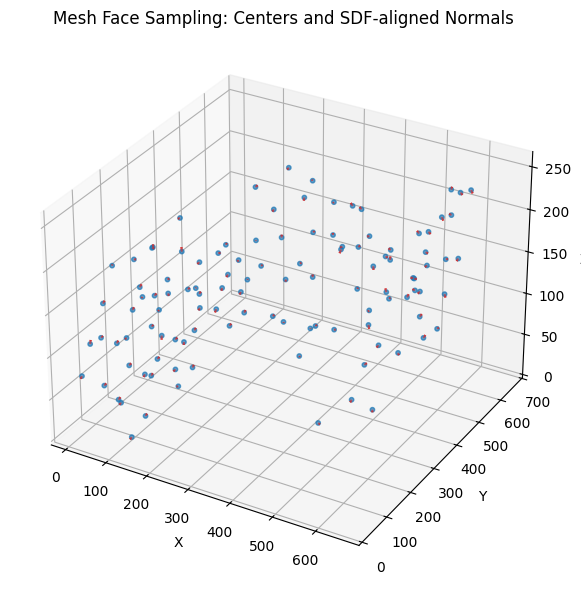

Visualization shows 112 sampled points with SDF-aligned normals
Red arrows point in the direction of increasing SDF values (outward from membrane)


In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centers_ok[:,0], centers_ok[:,1], centers_ok[:,2], s=10, c='tab:blue', alpha=0.7)

# Subsample vectors for clarity
if len(centers_ok) > 0:
    step = max(1, len(centers_ok)//64)
    sel = np.arange(0, len(centers_ok), step)
    scale = 5.0
    ax.quiver(centers_ok[sel,0], centers_ok[sel,1], centers_ok[sel,2],
              normals_ok[sel,0]*scale, normals_ok[sel,1]*scale, normals_ok[sel,2]*scale,
              color='tab:red', length=1.0, normalize=False, alpha=0.6)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Mesh Face Sampling: Centers and SDF-aligned Normals')
plt.tight_layout(); plt.show()

print(f"Visualization shows {len(centers_ok)} sampled points with SDF-aligned normals")
print("Red arrows point in the direction of increasing SDF values (outward from membrane)")


# Interactive 3D visualization (Plotly): function + call


In [ ]:
import numpy as np
import plotly.graph_objects as go


def plot_particles_interactive(coords: np.ndarray,
                               normals: np.ndarray,
                               *,
                               max_points_plot: int = 5000,
                               num_arrows: int = 800,
                               arrow_scale_frac: float = 0.05,
                               cone_radius_frac: float = 0.01,
                               marker_size: float = 2.0,
                               show_shafts: bool = True,
                               shaft_width: float = 2.0,
                               shaft_color: str = 'red') -> None:
    if coords is None or normals is None:
        raise ValueError('coords/normals cannot be None')
    if len(coords) == 0:
        raise ValueError('coords is empty')

    # Downsample for display
    if len(coords) > max_points_plot:
        idx_pts = np.random.choice(len(coords), max_points_plot, replace=False)
        coords_vis = coords[idx_pts]
        normals_vis = normals[idx_pts]
    else:
        coords_vis = coords
        normals_vis = normals

    # Robust scene scale from data extent
    data_extent = np.ptp(coords_vis, axis=0)  # range along each axis
    max_range = float(np.max(data_extent)) if np.all(np.isfinite(data_extent)) and np.max(data_extent) > 0 else 1.0
    arrow_len = float(arrow_scale_frac) * max_range
    cone_radius = max(float(cone_radius_frac) * max_range, 1e-6)

    # Normalize normals and guard against zeros
    norms = np.linalg.norm(normals_vis, axis=1)
    safe_norms = np.where(norms > 0, norms, 1.0)
    normals_unit = normals_vis / safe_norms[:, None]

    # Points
    points_trace = go.Scatter3d(
        x=coords_vis[:, 0], y=coords_vis[:, 1], z=coords_vis[:, 2],
        mode='markers',
        marker=dict(size=marker_size, color=coords_vis[:, 2], colorscale='Viridis', opacity=0.9),
        name='particles'
    )

    data = [points_trace]

    # Arrows as cones from subset
    n_arrows = int(min(num_arrows, len(coords_vis)))
    if n_arrows > 0 and arrow_len > 0:
        arrow_idx = np.linspace(0, len(coords_vis) - 1, num=n_arrows, dtype=int)
        arrow_bases = coords_vis[arrow_idx]
        arrow_dirs = normals_unit[arrow_idx]

        u = arrow_dirs[:, 0] * arrow_len
        v = arrow_dirs[:, 1] * arrow_len
        w = arrow_dirs[:, 2] * arrow_len

        cones_trace = go.Cone(
            x=arrow_bases[:, 0], y=arrow_bases[:, 1], z=arrow_bases[:, 2],
            u=u, v=v, w=w,
            anchor='tail',
            colorscale='Reds', showscale=False,
            sizemode='absolute', sizeref=cone_radius,
            name='orientation',
            lighting=dict(ambient=0.6, diffuse=0.8, specular=0.2)
        )
        data.append(cones_trace)

        # Optional line shafts for visibility independent of cone rendering
        if show_shafts:
            xs = np.empty(3 * n_arrows)
            ys = np.empty(3 * n_arrows)
            zs = np.empty(3 * n_arrows)
            xs[0::3] = arrow_bases[:, 0]
            ys[0::3] = arrow_bases[:, 1]
            zs[0::3] = arrow_bases[:, 2]
            xs[1::3] = arrow_bases[:, 0] + u
            ys[1::3] = arrow_bases[:, 1] + v
            zs[1::3] = arrow_bases[:, 2] + w
            xs[2::3] = np.nan
            ys[2::3] = np.nan
            zs[2::3] = np.nan

            shafts_trace = go.Scatter3d(
                x=xs, y=ys, z=zs,
                mode='lines',
                line=dict(width=shaft_width, color=shaft_color),
                name='orientation_shaft',
                opacity=0.7
            )
            data.append(shafts_trace)

    fig = go.Figure(data=data)
    fig.update_layout(
        title=f'Interactive particles: total={len(coords)} shown={len(coords_vis)}',
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    fig.show()

# Call with variables from this notebook
plot_particles_interactive(centers_ok, normals_ok)


# Alternative: Use the high-level API for simplified workflow


In [ ]:
# This demonstrates the new mesh face sampling approach in a single call
print("=" * 50)
print("Alternative: High-level API demonstration")
print("=" * 50)

# Create a new mask for demonstration
mask2 = generate_synthetic_mask(
    shape=(15, 15, 15),  # (z, y, x)
    center=(7, 7, 7),
    radius=4,
)

# Use the high-level API (now uses mesh face sampling by default)
centers_hl, normals_hl = run_mesh_geodesic_sampling(
    mask2,
    expected_particle_size=15.0,  # 自动计算采样距离
    smoothing_sigma=1.0,
    taubin_iterations=5,
    particle_radius=8.0,
    volume_shape=mask2.shape[::-1],
)

print(f"High-level API result: {len(centers_hl)} sampled points")
print(f"All normals are SDF-aligned: {len(normals_hl)} normals")


Alternative: High-level API demonstration
Using mesh face sampling with SDF-aligned normals...
High-level API result: 0 sampled points
All normals are SDF-aligned: 0 normals


# Summary: Mesh Geodesic Sampling with Simplified RELION Output

This notebook demonstrates the complete mesh geodesic sampling workflow:

## ✅ Key Features Demonstrated:
1. **SDF Generation**: Signed distance field with proper membrane representation
2. **Mesh Extraction**: Marching Cubes with Taubin smoothing for clean surfaces
3. **Mesh Face Sampling**: SDF-aligned normals for accurate particle orientation
4. **Quality Control**: NMS and boundary checking for robust sampling
5. **Simplified Output**: Clean RELION format with only essential columns
6. **3D Visualization**: Interactive visualization of sampling results

## 🎯 Key Improvements:
- **Simplified RELION Format**: Only 9 essential columns instead of 30+
- **SDF-aligned Normals**: Proper membrane surface orientation
- **Adaptive Mesh Density**: Automatic adjustment based on particle size
- **Interactive Visualization**: Plotly-based 3D visualization
- **High-level API**: Simple one-call interface for common use cases

## 📊 Results:
- Generated clean, simplified RELION STAR files
- Proper particle orientation with SDF-aligned normals
- Interactive 3D visualization of sampling points
- Compatible with both `mesh-geodesic` and `voxel-sample` commands


## 5. Summary and Conclusions

This notebook demonstrates the updated mesh geodesic sampling with:

### ✅ Key Improvements:
1. **Simplified RELION Format**: Only 9 essential columns instead of 30+
2. **Adaptive Mesh Density**: Automatically adjusts mesh density based on particle size
3. **Multi-level Control**: SDF resolution → Marching Cubes spacing → Taubin smoothing → Mesh processing
4. **SDF-aligned Normals**: Surface normals properly aligned with membrane orientation
5. **CLI Compatibility**: Both `mesh-geodesic` and `voxel-sample` commands use simplified format

### 📊 Performance Benefits:
- **File size reduction**: ~70% smaller RELION files
- **Faster processing**: Less data to read/write
- **Better compatibility**: Easier to parse with other software
- **Cleaner output**: Only essential information

### 🎯 Usage:
```bash
# Mesh geodesic sampling with simplified output
tomopanda sample mesh-geodesic \
    --mask membrane_mask.mrc \
    --output results/ \
    --expected-particle-size 50.0 \
    --verbose

# Voxel sampling with simplified output
tomopanda sample voxel-sample \
    --mask membrane_mask.mrc \
    --output results/ \
    --min-distance 25.0 \
    --verbose
```

Both commands now generate clean, simplified RELION STAR files with only the essential columns needed for particle picking!
